In [8]:
from PIL import Image
import pytesseract
import cv2
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import skimage

In [9]:
print(np.__version__)

1.15.0


In [10]:
img = cv2.imread('images/input/MMC_01_200dpi.tiff')

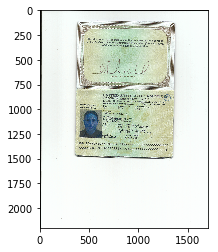

In [11]:
plt.imshow(img)

## Preprocessing

### I.  Otsu binarization

In [12]:
def edgeDetection(image):
    image = imutils.resize(image, height = 500)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 75, 200)
    
    return edged

In [13]:
def findContour(edged):
    cnts, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
     
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        if len(approx) == 4:
            screenCnt = approx
            break

    # cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
    # cv2.imshow("Outline", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return screenCnt

In [14]:
def preprocess(image,args="thresh"):
    # load the example image and convert it to grayscale
    # image = img
    try:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        if args == "thresh":
            gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
 
        elif args == "blur":
            gray = cv2.medianBlur(gray, 3)

    except:
        gray = image

    filename = "{}.jpg".format(os.getpid())
    cv2.imwrite("images/output/"+filename, gray)

    # return gray
    return filename

In [15]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

In [16]:
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
 
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
 
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
 
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
 
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
 
    # return the warped image
    return warped

In [17]:
def scan(screenCnt, image):
    ratio = image.shape[0] / 500.0

    warped = four_point_transform(image, screenCnt.reshape(4, 2) * ratio)
     
    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    T = threshold_local(warped, 11, offset = 10, method = "gaussian")
    warped = (warped > T).astype("uint8") * 255

    # kernel = np.ones((1,5), np.uint8)  # note this is a HORIZONTAL kernel
    # kernel = np.array([(0,1,0),(1,1,1),(0,1,0)])
    # e_im = cv2.dilate(warped, kernel, iterations=1)
    # e_im = cv2.erode(e_im, kernel, iterations=2) 

    # cv2.imshow("Original", imutils.resize(orig, height = 650))
    # cv2.imshow("Scanned", imutils.resize(warped, height = 650))
    # cv2.imshow("Scanne", imutils.resize(e_im, height = 650))
    # cv2.waitKey(0)

    return warped

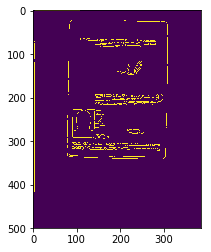

In [19]:
filename = "images/input/MMC_01_200dpi.tiff"
image = cv2.imread(filename)
edged = edgeDetection(image)
plt.imshow(edged)

In [ ]:
screenCnt = findContour(edged)
scannedImage = scan(screenCnt,image)

### OCR
processedImg = preprocess(scannedImage)
ocr(processedImg)

cv2.imshow("Scanned", imutils.resize(scannedImage, height = 650))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
text = pytesseract.image_to_string(Image.open('images/output/31668.jpg'))
print(text)